## How to get Kur started
- install: `pip install kur`
- check: `kur --version`
- train: `kur -v train mnist.yml`
- test: `kur -v test mnist.yml`
- evaluate: `kur -v evaluate mnist.yml`
- detailed process: `-v`(detail) or `-vv` (more detailed)
- to speed up: use 480 out of 60000 training data, 10 batches 32 each, 160 test data



In [1]:
!kur --version

Kur, by Deepgram -- deep learning made easy
Version: 0.3.0
Homepage: https://kur.deepgram.com


## mnist.yml to accompany mnist-default.yml
```yml
	train:
	  data:  # to get data 
	    - mnist:                 # it looks very different from Kurfile template on dataset? #############
	        images:
	          url: "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
	        labels:
	          url: "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"

	model:
	  - input: images

	  - convolution:
	      kernels: 64
	      size: [2, 2]
	  - activation: relu

	  - convolution:
	      kernels: 96
	      size: [2, 2]
	  - activation: relu

      - pool: [3, 3]                  # add a pooling layer with shape 3x3

	  - convolution:
	      kernels: 96
	      size: [2, 2]
	  - activation: relu

	  - flatten:
	  - dense: [64, 10]
      
	  - activation: softmax      # apply softmax activation to output layer
	    name: labels             # why no `-`? do I need to know Ninja2 to understand the usage   ? ######
        

	include: mnist-defaults.yml  # to define default setting 
```

In [12]:
%pycat mnist.yml # to display the file content in a seperate window

## Understanding mnist-default.yml
- more complex models demand more data
- as more complex model has more parameters which increase the likelihood of overfitting
- more data can reduce overfitting 
- we can get rid of the line `num_batches: 10` from `mnist-defaults.yml` to use the entire dataset

```yaml
---
                         # Declare the loss function that is used during training/validation/testing.
loss:
                         # It is a list of loss functions, one for each model output.
                         # The MNIST example only has one output, named "labels".
  - target: labels
    name: categorical_crossentropy

                         # The "include" section in "mnist.yml" is magical, and will merge this section
                         # into the section in "mnist.yml".
                         ######## merge: this entire mnist-default.yml, not a few lines here? ##############
train:
                         # Let's include checksums for all of the data we download.
                         # note: in mnist.yml there are urls for dataset downloading for training set
                         ######## what is checksums for?                                ####################
  data:
    - mnist:
        images:
          checksum: 440fcabf73cc546fa21475e81ea370265605f56be210a4024d2ca8f203523609
          path: "~/kur"  # why didn't find dataset in the folder                                  ##########
        labels:
          checksum: 3552534a0a558bbed6aed32b30c495cca23d567ec52cac8be1a0730e8010255c
          path: "~/kur"

                         # As we discuss in "Examples" in the documentation, we only train on the first
                         # batches each epoch. This is just to make getting through the MNIST example
                         # nice and quick on slow/CPU-only machines. If you have a GPU, feel free to
                         # remove the "provider:" section entirely.
  provider:
    num_batches: 15

                         # How many epochs to train for.
  epochs: 10

                         # Here, we use the MNIST test set as a validation set (more generally, you'll
                         # want train, validation, and test sets; but we ignore this for the MNIST
                         # example). The funky "&validation" is just a YAML anchor, so we can reference
                         # this section later.
validate: &validate
  data:
    - mnist:
        images:          # why having url here, not in train.data section?               ###################
                         # validation set is a different dataset ##
          url: "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz"
          checksum: 8d422c7b0a1c1c79245a5bcf07fe86e33eeafee792b84584aec276f5a2dbc4e6
          path: "~/kur"
        labels:
          url: "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
          checksum: f7ae60f92e00ec6debd23a6088c31dbd2371eca3ffa0defaefb259924204aec6
          path: "~/kur"

                         # Let's also use less data for validation, just to speed it along.
  provider:
    num_batches: 100

                         # Where to save the model weights that have the lowest validation loss.
                         # above "the lowest validation loss" means the last loss value of 10 epochs? ######
  weights: mnist.w

                         # Let's define the test set, used if you execute something like:
                         # `kur test mnist.yml`
                         # The funky "*validation" is just a YAML alias, so we basically are setting the
                         # "test" section" to be the same as the "validate" section.
                         # this is why `validate: &validate` is very necessary and useful ##################
test: *validate

                         # This is the evaluation section, used during `kur evaluate mnist.yml`.
                         # The funky "<<: *validate" is just YAML, and basically means "copy all of the
                         # keys from 'validate', and then add/replace the 
                         # what does "copy all the keys from 'validate' mean? and "add/replace" what? ######
                         # but how exactly *validate and <<: *validate differ? #############################
evaluate:
  <<: *validate
  
                         # Use the entire testing set for evaluation.
  provider:
    num_batches: null

                         # Where do we want to store the output file?
                         # Here, we are just storing it as a Python pickle.
                         # if needed, I can change destination by adding `folderName/`?#####################
  destination: mnist.results.pkl

                         # This is a list of post-processing hooks. Here, we want to produce the
                         # digit-by-digit accuracy table (just called "mnist").
                         # What exactly is such "digit-by-digit accuracy table"? ###########################
  hooks:
    - mnist
...

```

In [4]:
%pwd
%cd /Users/Natsume/Downloads/kur/examples/
!kur -v train mnist.yml

/Users/Natsume/Downloads/kur/examples
[INFO 2017-02-26 13:37:49,072 kur.kurfile:638] Parsing source: mnist.yml, included by top-level.
[INFO 2017-02-26 13:37:49,079 kur.kurfile:638] Parsing source: mnist-defaults.yml, included by mnist.yml.
[INFO 2017-02-26 13:37:49,090 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 13:37:49,961 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 13:37:49,962 kur.providers.batch_provider:60] Maximum number of batches set to: 15
[INFO 2017-02-26 13:37:50,098 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 13:37:50,098 kur.providers.batch_provider:60] Maximum number of batches set to: 100
[INFO 2017-02-26 13:37:50,099 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 13:37:50,099 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 13:37:50,099 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 13:37:51,162 kur.backend.keras_backend

In [17]:
!kur -v train mnist.yml # it does not build upon previous runs

[INFO 2017-02-26 14:26:00,915 kur.kurfile:638] Parsing source: mnist.yml, included by top-level.
[INFO 2017-02-26 14:26:00,922 kur.kurfile:638] Parsing source: mnist-defaults.yml, included by mnist.yml.
[INFO 2017-02-26 14:26:00,938 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 14:26:01,852 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 14:26:01,853 kur.providers.batch_provider:60] Maximum number of batches set to: 15
[INFO 2017-02-26 14:26:01,999 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 14:26:01,999 kur.providers.batch_provider:60] Maximum number of batches set to: 100
[INFO 2017-02-26 14:26:02,000 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 14:26:02,000 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 14:26:02,000 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 14:26:03,098 kur.backend.keras_backend:191] Keras is loaded. The backend is:

In [5]:
!kur -v test mnist.yml

[INFO 2017-02-26 13:41:33,687 kur.kurfile:638] Parsing source: mnist.yml, included by top-level.
[INFO 2017-02-26 13:41:33,694 kur.kurfile:638] Parsing source: mnist-defaults.yml, included by mnist.yml.
[INFO 2017-02-26 13:41:33,705 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 13:41:33,861 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 13:41:33,861 kur.providers.batch_provider:60] Maximum number of batches set to: 100
[INFO 2017-02-26 13:41:33,862 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 13:41:33,862 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 13:41:33,862 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 13:41:34,776 kur.backend.keras_backend:191] Keras is loaded. The backend is: theano
[INFO 2017-02-26 13:41:34,776 kur.model.model:260] Enumerating the model containers.
[INFO 2017-02-26 13:41:34,777 kur.model.model:265] Assembling the model dependency graph.
[I

In [6]:
!kur -v evaluate mnist.yml

[INFO 2017-02-26 13:41:57,085 kur.kurfile:638] Parsing source: mnist.yml, included by top-level.
[INFO 2017-02-26 13:41:57,091 kur.kurfile:638] Parsing source: mnist-defaults.yml, included by mnist.yml.
[INFO 2017-02-26 13:41:57,104 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 13:41:57,278 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 13:41:57,279 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 13:41:57,280 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 13:41:57,280 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 13:41:57,938 kur.backend.keras_backend:191] Keras is loaded. The backend is: theano
[INFO 2017-02-26 13:41:57,938 kur.model.model:260] Enumerating the model containers.
[INFO 2017-02-26 13:41:57,939 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-02-26 13:41:57,939 kur.model.model:280] Connecting the model graph.
[INFO 2017-02-26 13:41:5

## Demonstrate Flexibility of Kur with CIFAR-10

**Check out cifar.yml**


```yaml
---

settings:

  # Where to get the data
  cifar: &cifar
    url: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    checksum: "6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce"
    path: "~/kur"                 # download and save dataset in kur directory, if so why not see it ######

  # Backend to use                                        what does "backend to use" mean here? ###########
  backend:
    name: keras

  # Hyperparameters
  cnn:
    kernels: [64, 32]
    size: [2, 2]
    strides: [1, 1]                  # why in mnist.yml or mnist-default.yml we don't have strides#########

# The model itself.
# This is parsed immediately after the "parameters" block.
model:
  - input: images
  - for:
      range: "{{ cnn.kernels|length }}"
      iterate:
        - convolution:
            kernels: "{{ cnn.kernels[index] }}"
            size: "{{ cnn.size }}"
            strides: "{{ cnn.strides }}"
        - activation: relu
  - flatten:
  - dense: 10
  - activation: softmax
    name: labels
        
train:
  data:
    - cifar:
        <<: *cifar
        parts: [1, 2, 3, 4]
  provider:
    batch_size: 32
    num_batches: 2
  log: cifar-log                   # save a log file to ``cifar-log`` (in the current working directory)
  epochs: 2
  weights:
    initial: cifar.best.valid.w
    best: cifar.best.train.w
    last: cifar.last.w

  optimizer:
    name: adam
    learning_rate: 0.001

validate:
  data:
    - cifar:
       <<: *cifar
       parts: 5
  provider:
    num_batches: 2
  weights: cifar.best.valid.w

test: &test
  data:
    - cifar:
       <<: *cifar
       parts: test
  weights: cifar.best.valid.w
  provider:
    num_batches: 10

evaluate:
  <<: *test
  destination: cifar.results.pkl

loss:
  - target: labels
    name: categorical_crossentropy
...

```

In [20]:
!kur -v train cifar.yml

[INFO 2017-02-26 18:11:29,850 kur.kurfile:638] Parsing source: cifar.yml, included by top-level.
[INFO 2017-02-26 18:11:29,864 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 18:11:29,905 kur.loggers.binary_logger:87] Log does not exist. Creating path: cifar-log
Downloading: 100%|████████████████████████| 170M/170M [25:05<00:00, 113Kbytes/s]
[INFO 2017-02-26 18:36:37,251 kur.utils.network:65] File downloaded: /Users/Natsume/kur/cifar-10-python.tar.gz
[INFO 2017-02-26 18:36:45,391 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 18:36:45,391 kur.providers.batch_provider:60] Maximum number of batches set to: 2
[INFO 2017-02-26 18:36:51,621 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 18:36:51,621 kur.providers.batch_provider:60] Maximum number of batches set to: 2
[INFO 2017-02-26 18:36:51,623 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 18:36:51,623 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 1

In [21]:
!kur -v train cifar.yml

[INFO 2017-02-26 18:40:29,021 kur.kurfile:638] Parsing source: cifar.yml, included by top-level.
[INFO 2017-02-26 18:40:29,035 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 18:40:29,062 kur.loggers.binary_logger:63] Loading log data: cifar-log
[INFO 2017-02-26 18:40:36,827 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 18:40:36,827 kur.providers.batch_provider:60] Maximum number of batches set to: 2
[INFO 2017-02-26 18:40:42,897 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 18:40:42,897 kur.providers.batch_provider:60] Maximum number of batches set to: 2
[INFO 2017-02-26 18:40:42,898 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 18:40:42,898 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 18:40:42,898 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 18:40:43,876 kur.backend.keras_backend:191] Keras is loaded. The backend is: theano
[INFO 2017-02

In [22]:
!kur -v evaluate cifar.yml

[INFO 2017-02-26 18:41:33,882 kur.kurfile:638] Parsing source: cifar.yml, included by top-level.
[INFO 2017-02-26 18:41:33,897 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 18:41:38,753 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 18:41:38,753 kur.providers.batch_provider:60] Maximum number of batches set to: 10
[INFO 2017-02-26 18:41:38,754 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 18:41:38,754 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 18:41:38,754 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 18:41:39,609 kur.backend.keras_backend:191] Keras is loaded. The backend is: theano
[INFO 2017-02-26 18:41:39,609 kur.model.model:260] Enumerating the model containers.
[INFO 2017-02-26 18:41:39,609 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-02-26 18:41:39,609 kur.model.model:280] Connecting the model graph.
[INFO 2017-02-26 18:41:40,035 

In [23]:
!kur -v test cifar.yml

[INFO 2017-02-26 18:42:18,612 kur.kurfile:638] Parsing source: cifar.yml, included by top-level.
[INFO 2017-02-26 18:42:18,627 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 18:42:23,592 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 18:42:23,592 kur.providers.batch_provider:60] Maximum number of batches set to: 10
[INFO 2017-02-26 18:42:23,593 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 18:42:23,593 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 18:42:23,593 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 18:42:24,241 kur.backend.keras_backend:191] Keras is loaded. The backend is: theano
[INFO 2017-02-26 18:42:24,242 kur.model.model:260] Enumerating the model containers.
[INFO 2017-02-26 18:42:24,242 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-02-26 18:42:24,242 kur.model.model:280] Connecting the model graph.
[INFO 2017-02-26 18:42:24,722 

In [113]:
%pycat speech.yml

## Speech.yml displayed

```yml
---

###############################################################################
# Pro-tips:
#
# - Use YAML's anchors! This let's you define a value (even a dictionary), and
#   reuse, or even change, parts of it later. YAML anchors are incredible for
#   defining constant values that you want to reuse all over the place. You can
#   define an anchor like this:
#     KEY: &my_anchor
#   Note that the value of KEY can be anything. All of these are allowed:
#     KEY: &my_anchor "my value"
#     KEY: &my_ancor
#       A: B
#       C: D
#     KEY: &my_anchor [1, 2, 3]
#   You can then refer back to your anchors like this:
#     ANOTHER_KEY: *my_anchor
#   This sets the value of ANOTHER_KEY to be the same thing as the original
#   KEY. Now let's say that your anchor is a dictionary, but you want to refer
#   to it with modified values later. Try this:
#     KEY: &my_anchor
#       FIRST: VALUE_1
#       SECOND: VALUE_2
#     ANOTHER_KEY:
#       <<: *my_anchor
#       SECOND: VALUE_2_NEW
#       THIRD: VALUE_3
#     MORE_KEY: *my_anchor
#   These are 100% equivalent to this more verbose structure:
#     KEY:
#       FIRST: VALUE_1
#       SECOND: VALUE_2
#     ANOTHER_KEY:
#       FIRST: VALUE_1
#       SECOND: VALUE_2_NEW
#       THIRD: VALUE_3
#     MORE_KEY:
#       FIRST: VALUE_1
#       SECOND: VALUE_2
#
# - Use the Jinja2 engine! It is really powerful, and it's most appropriately
#   used to do on-the-fly interpretation/evaluation of values in the "model"
#   section of the Kurfile.
#
# - So how do you know when to use YAML anchors as opposed to Jinja2
#   expressions? Here are some tips.
#
#   YAML anchors only work within a single YAML file, and are evaluated the
#   moment the file is loaded. This means you can't use YAML anchors from a
#   JSON Kurfile, and you can't reference anchors in other Kurfiles.
#
#   Jinja2 is interpreted after all Kurfiles are loaded, which means that
#   many different Kurfiles can share variables via Jinja2. Jinja2
#   expressions can also be used in JSON Kurfiles.
#
#   It's almost like YAML anchors are "compile-time constants" but Jinja2
#   expressions are interpreted at run-time. As a result, the value of a
#   Jinja2 expression could be different at different points in the
#   Kurfile (e.g., if you use Jinja2 to reference the previous layer in a
#   model, obviously the interpretation/value of "previous layer" resolves
#   to something different for the second layer in the model as compared to the
#   fifth layer in the model.

###############################################################################
settings:

  # Deep learning model
  cnn:
    kernels: 1000
    size: 11
    stride: 2
  rnn:
    size: 1000
    depth: 3
  vocab:
    # Need for CTC
    size: 28

  # Setting up the backend.
  backend:
    name: keras
    backend: tensorflow

  # Batch sizes
  provider: &provider
    batch_size: 16
    force_batch_size: yes

  # Where to put the data.
  data: &data
    path: "~/kur"
    type: spec
    max_duration: 50
    max_frequency: 8000
    normalization: norm.yml

  # Where to put the weights
  weights: &weights weights

###############################################################################
model:

  # This is Baidu's DeepSpeech model:
  #   https://arxiv.org/abs/1412.5567
  # Kur makes prototyping different versions of it incredibly easy.

  # The model input is audio data (called utterances).
  - input: utterance

  # One-dimensional, variable-size convolutional layers to extract more
  # efficient representation of the data.
  - convolution:
      kernels: "{{ cnn.kernels }}"
      size: "{{ cnn.size }}"
      strides: "{{ cnn.stride }}"
      border: valid
  - activation: relu
  - batch_normalization

  # A series of recurrent layers to learn temporal sequences.
  - for:
      range: "{{ rnn.depth }}"
      iterate:
        - recurrent:
            size: "{{ rnn.size }}"
            sequence: yes
        - batch_normalization

  # A dense layer to get everything into the right output shape.
  - parallel:
      apply:
        - dense: "{{ vocab.size + 1 }}"
  - activation: softmax

  # The output is the transcription.
  - output: asr

###############################################################################
train:

  data:
    # A "speech_recognition" data supplier will create these data sources:
    #   utterance, utterance_length, transcript, transcript_length, duration
    - speech_recognition:
        <<: *data
        url: "http://kur.deepgram.com/data/lsdc-train.tar.gz"
        checksum: >-
          fc414bccf4de3964f895eaa9d0e245ea28810a94be3079b55505cf0eb1644f94

  weights: *weights
  provider:
    <<: *provider
    sortagrad: duration

  log: log

  optimizer:
    name: sgd
    nesterov: yes
    learning_rate: 2e-4
    momentum: 0.9
    clip:
      norm: 100

###############################################################################
validate: &validate
  data:
    - speech_recognition:
        <<: *data
        url: "http://kur.deepgram.com/data/lsdc-test.tar.gz"
        checksum: >-
          e1c8cf9cd57e8c1ae952b6e4e40dcb5c8e3932c81ecd52c090e4a05c8ebbea2b

  weights: *weights
  provider: *provider

  hooks:
    - transcript

###############################################################################
test: *validate

###############################################################################
evaluate: *validate

###############################################################################
loss:
  - name: ctc
    # The model's output (its best-guest transcript).
    target: asr
    # How long the corresponding audio utterance is.
    input_length: utterance_length
    relative_to: utterance
    # How long the ground-truth transcript is.
    output_length: transcript_length
    # The ground-truth transcipt itself.
    output: transcript

...
```

In [18]:
!kur -v train speech.yml

[INFO 2017-02-26 14:32:31,969 kur.kurfile:638] Parsing source: speech.yml, included by top-level.
[INFO 2017-02-26 14:32:31,993 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 14:32:32,051 kur.loggers.binary_logger:63] Loading log data: log
[INFO 2017-02-26 14:32:56,353 kur.supplier.speechrec:143] Restoring normalization statistics: norm.yml
[INFO 2017-02-26 14:32:56,353 kur.utils.normalize:185] Restoring normalization state from: norm.yml
[INFO 2017-02-26 14:33:02,442 kur.supplier.speechrec:299] Inferring vocabulary from data set.
[INFO 2017-02-26 14:33:02,476 kur.supplier.speechrec:334] Loaded a 28-word vocabulary.
[INFO 2017-02-26 14:33:02,477 kur.providers.batch_provider:54] Batch size set to: 16
[INFO 2017-02-26 14:33:02,477 kur.providers.batch_provider:70] Batch provider will force batches of exactly 16 samples.
[INFO 2017-02-26 14:33:05,039 kur.supplier.speechrec:143] Restoring normalization statistics: norm.yml
[INFO 2017-02-26 14:33:05,039 kur.utils.normalize:185] Restorin

### How to stop training after one hour and test the performance of the trained model?

In the post, the author [indicated it is possible to train model just for an hour](https://hyp.is/AdYWLPs5EeaGCsMcxJGeRw/blog.deepgram.com/how-to-train-baidus-deepspeech-model-with-kur/). 
So, I wonder: 

> How to stop the training whenever I want?      
> How to test the trained model with an audio? 

###  speed up running 
- stop it if it is too slow, ctrl + c is equivalent to stop button above
- select a smaller sample to run here, by chaning kurfile

### **Load binary log file in python**


```
	from kur.loggers import BinaryLogger
	data = BinaryLogger.load_column(LOG_PATH, STATISTIC)
```
- LOG_PATH is the path to the log file (e.g., cifar-log)
- STATISTIC is one of the logged statistics
- data will be a `Numpy array`
- To find available statistics, just list the available files in the ``LOG_PATH``, like this:

```

	$ ls cifar-log
	training_loss_labels
	training_loss_total
	validation_loss_labels
	validation_loss_total

For an example of using this log data, see our Tutorial_.

```

In [24]:
!ls

cifar-log          cifar.results.pkl  mnist.results.pkl  speech.yml
cifar.best.train.w cifar.yml          mnist.w
cifar.best.valid.w log                mnist.yml
cifar.last.w       mnist-defaults.yml norm.yml


In [25]:
!ls cifar-log

training_loss_labels   validation_loss_labels
training_loss_total    validation_loss_total


In [27]:
from kur.loggers import BinaryLogger
data = BinaryLogger.load_column("cifar-log/", "training_loss_labels")

In [28]:
data

array([ 2.28883553,  2.38287163,  2.32052898,  2.27693081], dtype=float32)

## Getting started with Kur

```yaml
kur [-v] {train | test | evaluate | build} KURFILE.yml
```

**What does `build` do?**
- does not load the data set, and doesn't actually start training. 
- just assembles the model. 
- useful for debugging the construction of models, looking for obvious problems
- while not bothering with loading and training on data just yet.

**check process details**
- `-v` to enable INFO-level output, or
- `-vv` to enable DEBUG-level ouput (there's a lot). 
- You should definitely pay attention to any warnings or errors: they are indicative of something unexpected or wrong. - If Kur seems 'stuck', try enabling verbose output to see what it is up to.

**Use yaml**
- YAML documents need to start with three dashes: ``---``. Everything
  you add to the file should go below those dashes.
- Documents can be explicitly terminated by three periods: ``...``, but this is
  optional.
- YAML is a "whitespace matters" language. You should never use tabs in YAML.
- YAML files should use the ``.yaml`` or ``.yml`` extension.
- YAML comments start with the hash character: ``#``

### Kurfile template

```yml

---

# Other kurfiles to load (optional)
include:                               # only need this if you've split your specification into
                                       # multiple files. Otherwise, you can leave it empty or just remove it.

# Global variables go here (optional)
                                    # to reference using the templating engine later (e.g., data sets or model
                                    # hyperparameters). If you don't have any variables, you can just leave this
                                    # section empty or remote it.
settings:   

# Your core model goes here (required)
model:

  # Input data
  - input: INPUT                                                          # put in variable name for features

  # ... other layers ...

  # Last layer. Change "softmax" if it is appropriate.
  - activation: softmax
    name: OUTPUT                                                          # put in variable name for labels
                                                                          # check containers ################

# All the information you need for training.
train:

  # Where to get training data from.
  # NOTE: `TRAIN_DATA` needs to have dictionary keys named `INPUT` and
  #       `OUTPUT`, corresponding to the `INPUT` and `OUTPUT` names in the
  #       model section above.
  # The values in that dictionary should be numpy arrays that you
  #  want to feed into the Kur model
  data:
    - pickle: TRAIN_DATA

  # Try playing with the batch size and watching accuracy and speed.
  provider:
    batch_size: 32

  # How many epochs to train for.
  epochs: 10

  # Where to load and save weights.
  weights:
    initial: INITIAL_WEIGHTS
    best: BEST_TRAINING_LOSS_WEIGHTS                                      # weights with lowest loss #####
    last: MOST_RECENT_WEIGHTS                                     # weights with the last iterations #####

  # The optimizer to use. Try doubling or halving the learning rate.
  optimizer:
    name: adam
    learning_rate: 0.001

# You need this section if you want to run validation checks during
# training.
validate:
  data:
    - pickle: VALIDATION_DATA

  # Where to save the best validation weights.
  weights: BEST_VALIDATION_LOSS_WEIGHTS

# You need this section only if you want to run standalone test runs to
# calculate loss.
test:
  data:
    - pickle: TEST_DATA
  # Which weights to use for testing.
  weights: BEST_VALIDATION_LOSS_WEIGHTS

# This section is for trying out your model on new data.
evaluate:
  # The data to supply as input. Unlike the train/validate/test sections,
  # you do not need a corresponding `OUTPUT` key. But if you do supply one,    # no need for label variable ###
  # Kur can save it to the output file for you so it's easy to use during
  # post-processing
  data:
    - pickle: NEW_DATA

  # Which weights to use for evaluation.
  weights: BEST_VALIDATION_LOSS_WEIGHTS

  # Where to save the result (as a Python pickle)
  destination: RESULTS.pkl

# Required for training, validation and testing
loss:
  # You need an entry whose target is `OUTPUT` from the model section above.
  - target: OUTPUT

    # The name of the loss function. Change it if appropriate
    name: categorical_crossentropy
...


```

## Tutorial from scratch
**Create data-generating code with python and pickle**

In [30]:
%cd from_scratch/

/Users/Natsume/Downloads/kur/examples/from_scratch


In [31]:
%%writefile make_points.py

import sys
import pickle
import numpy

if len(sys.argv) != 3:
    print(
        'Usage: {} NUM-SAMPLES OUTPUT-FILE'.format(sys.argv[0]),
        file=sys.stderr
    )
    sys.exit(1)

_, num_samples, output_file = sys.argv
num_samples = int(num_samples)

x = numpy.array([
    numpy.random.uniform(-numpy.pi, numpy.pi, num_samples),
    numpy.random.uniform(-1, 1, num_samples)
]).T
y = (numpy.sin(x[:,0]) < x[:,1]).astype(numpy.float32) * 2 - 1

with open(output_file, 'wb') as fh:
    fh.write(pickle.dumps({'point' : x, 'above' : y}))

Writing make_points.py


**Run py code to create four datasets**

In [33]:
!python make_points.py 10000 train.pkl
!python make_points.py 1000 validate.pkl
!python make_points.py 1000 test.pkl
!python make_points.py 1000 evaluate.pkl

**Check the datasets created**

In [34]:
import pickle
import numpy
with open('train.pkl', 'rb') as fh:
     data = pickle.loads(fh.read())

print(list(data.keys()))

print(data['point'][:10])

print(data['above'][:10])


['above', 'point']
[[ 2.48266488  0.89491483]
 [-1.17371733  0.37450378]
 [-0.4435049   0.79330212]
 [-1.7577413   0.51205784]
 [ 1.51928989  0.83517366]
 [-2.71184137 -0.08747709]
 [ 2.21113158  0.22136771]
 [ 0.65728594 -0.54636853]
 [-0.464383   -0.71697229]
 [-1.63733696 -0.19025727]]
[ 1.  1.  1.  1. -1.  1. -1. -1. -1.  1.]


**Plot the datasets**
    

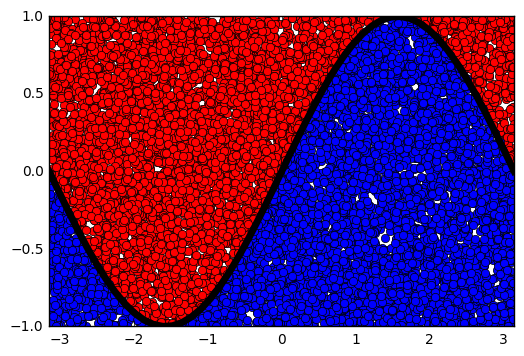

In [35]:
import matplotlib.pyplot as plt
above = data['above'] > 0
plt.xlim(-numpy.pi, numpy.pi)
plt.plot(data['point'][above,0], data['point'][above,1], 'ro')
plt.plot(data['point'][~above,0], data['point'][~above,1], 'bo')
X = numpy.linspace(-numpy.pi, numpy.pi)
plt.plot(X, numpy.sin(X), 'k', linewidth=5)
plt.show()    

**Build Kurfile for scratch**

In [38]:
%%writefile tutorial.yml

---
model:
  - input: point
  - dense: 128
  - activation: tanh
  - dense: 1
  - activation: tanh
    name: above

train:
  data:
    - pickle: train.pkl
  epochs: 10
  weights: best.w              # what if it is the first run without best.w? ####
  log: tutorial-log

validate:
  data:
    - pickle: validate.pkl
  weights: best.w

test:
  data:
    - pickle: test.pkl
  weights: best.w

evaluate:
  data:
    - pickle: evaluate.pkl
  weights: best.w
  destination: output.pkl

loss:
  - target: above
    name: mean_squared_error
...

Overwriting tutorial.yml


In [42]:
!kur -v train tutorial.yml

[INFO 2017-02-26 20:33:11,475 kur.kurfile:638] Parsing source: tutorial.yml, included by top-level.
[INFO 2017-02-26 20:33:11,481 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 20:33:11,490 kur.loggers.binary_logger:87] Log does not exist. Creating path: tutorial-log
[INFO 2017-02-26 20:33:11,492 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 20:33:11,493 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 20:33:11,494 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 20:33:11,494 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 20:33:11,494 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 20:33:12,578 kur.backend.keras_backend:191] Keras is loaded. The backend is: theano
[INFO 2017-02-26 20:33:12,579 kur.model.model:260] Enumerating the model containers.
[INFO 2017-02-26 20:33:12,579 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-02

In [43]:
!kur -v evaluate tutorial.yml

[INFO 2017-02-26 20:33:55,726 kur.kurfile:638] Parsing source: tutorial.yml, included by top-level.
[INFO 2017-02-26 20:33:55,732 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 20:33:55,743 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 20:33:55,744 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 20:33:55,744 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 20:33:55,744 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 20:33:56,787 kur.backend.keras_backend:191] Keras is loaded. The backend is: theano
[INFO 2017-02-26 20:33:56,788 kur.model.model:260] Enumerating the model containers.
[INFO 2017-02-26 20:33:56,788 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-02-26 20:33:56,788 kur.model.model:280] Connecting the model graph.
[INFO 2017-02-26 20:33:56,811 kur.model.model:284] Model inputs:  point
[INFO 2017-02-26 20:33:56,812 kur.model.model:285] Mode

In [44]:
!kur -v test tutorial.yml

[INFO 2017-02-26 20:34:23,138 kur.kurfile:638] Parsing source: tutorial.yml, included by top-level.
[INFO 2017-02-26 20:34:23,143 kur.kurfile:79] Parsing Kurfile...
[INFO 2017-02-26 20:34:23,155 kur.providers.batch_provider:54] Batch size set to: 32
[INFO 2017-02-26 20:34:23,156 kur.backend.backend:80] Creating backend: keras
[INFO 2017-02-26 20:34:23,156 kur.backend.backend:83] Backend variants: none
[INFO 2017-02-26 20:34:23,156 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-02-26 20:34:23,933 kur.backend.keras_backend:191] Keras is loaded. The backend is: theano
[INFO 2017-02-26 20:34:23,934 kur.model.model:260] Enumerating the model containers.
[INFO 2017-02-26 20:34:23,934 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-02-26 20:34:23,934 kur.model.model:280] Connecting the model graph.
[INFO 2017-02-26 20:34:23,941 kur.model.model:284] Model inputs:  point
[INFO 2017-02-26 20:34:23,942 kur.model.model:285] Mode

In [108]:
!ls tutorial-log

training_loss_above   validation_loss_above
training_loss_total   validation_loss_total


In [109]:
from kur.loggers import BinaryLogger
training_loss = BinaryLogger.load_column('tutorial-log', 'training_loss_total') 
validation_loss = BinaryLogger.load_column('tutorial-log', 'validation_loss_total') 
training_loss_above = BinaryLogger.load_column('tutorial-log', 'training_loss_above') 
print(training_loss_above) # get training loss for each epoch
training_loss

[ 0.48150712  0.41997892  0.31080344  0.21871923  0.17397912  0.14766917
  0.12866163  0.11509474  0.10548096  0.096509  ]


array([ 0.48150712,  0.41997892,  0.31080344,  0.21871923,  0.17397912,
        0.14766917,  0.12866163,  0.11509474,  0.10548096,  0.096509  ], dtype=float32)

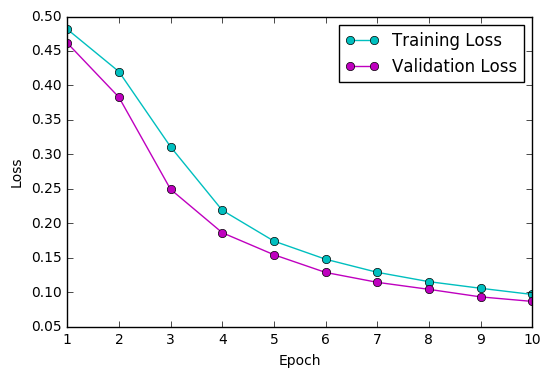

In [46]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
epoch = list(range(1, 1+len(training_loss)))
t_line, = plt.plot(epoch, training_loss, 'co-', label='Training Loss')
v_line, = plt.plot(epoch, validation_loss, 'mo-', label='Validation Loss')
plt.legend(handles=[t_line, v_line])
plt.show()

In [98]:
import pickle
import numpy
with open('output.pkl', 'rb') as fh:
    data = pickle.loads(fh.read())

print(type(data))    
print(list(data.keys()))
print(list(data['result'].keys()))
print(list(data['truth'].keys()))
print(type(data['result']['above']))
print(type(data['truth']['above']))
print(data['truth']['above'][0:5])
print(data['result']['above'][0:5])

<class 'dict'>
['result', 'truth']
['above']
['above']
<class 'list'>
<class 'list'>
[-1.0, -1.0, 1.0, 1.0, 1.0]
[array([-0.42590815], dtype=float32), array([-0.98776275], dtype=float32), array([ 0.96575135], dtype=float32), array([ 0.99999297], dtype=float32), array([ 0.99934262], dtype=float32)]


**Structure of output file**
```json
{
    'truth' : {
        'above' : list of float number -1.0 or 1.0
    },
    'result' : {
        'above' : list of np.array of float scalar between -1.0 and 1.0
    }
}
```

In [97]:
# diff = numpy.abs(data['truth']['above'] - data['result']['above']) < 1
diff = np.array([np.abs(a - b[0]) for a, b in zip(data['truth']['above'], data['result']['above'])]) < 1
correct = diff.sum()
total = len(diff)
correct / total * 100

98.0

In [104]:
import matplotlib.pyplot as plt
# should_be_above = np.array([a*(b[0]) for a, b in zip(data['truth']['above'], data['result']['above'])])
should_be_above = data['result']['above'][np.array(data['truth']['above']) > 0]
should_be_below = data['result']['above'][np.array(data['truth']['above']) < 0]
plt.xlabel('Model output')
plt.ylabel('Counts')
plt.xlim(-1, 1)
plt.hist(should_be_above, 20, facecolor='r', alpha=0.5, range=(-1, 1))
plt.hist(should_be_below, 20, facecolor='b', alpha=0.5, range=(-1, 1))
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

In [106]:
import pickle
import numpy
with open('output.pkl', 'rb') as fh:
    output = pickle.loads(fh.read())

with open('evaluate.pkl', 'rb') as fh:
    evaluate = pickle.loads(fh.read())

above = output['result']['above'].flatten() > 0

AttributeError: 'list' object has no attribute 'flatten'

### Questions to Kur team
How to make the most out of Kur? 
- Goal: I want a job in deep learning, and I would like to invest time in using kur and contribute to kur in any way I could
- Current status: I am taking deep learning foundation nanodegree like a full time student at the moment, and intend to take Driverless Nanodegree and Artificial Intelligence Nanodegree in late half of 2017.
- I love kur in the first sight, because I believe get deep learning intuition is priority and how to code everything up is essential but secondary. It looks kur can help me build and experiment on deep learning models with much greater efficiency and flexibility.
- but how flexible can kur be? can it be as flexible as tensorflow, which is the only library we are using at the moment for deep learning (at Udacity Deep learning foundation nanodegree). Also in the latest kur post on Baidu deep speech, author encourage us to implement deep learning papers with kur (I like this idea very much and I really want to do this), which indicates kur can be extremely flexible like tensorflow, to freely create all the newly invented techniques. Are there available examples to demonstrate such flexiblity of kur?
- Although it is exciting to see that kur requires users with no programming skills, I believe ability to understand and code in tensorflow should be a great help in studying and using kur. Meanwhile kur should be able to help me experiment on deep learning more efficiently and in depth than other libraries. However, I don't know how yet. Could you shed some light on this for me?
- One thing I can think of doing is trying to rewrite my projects in Udacity degree with Kur, this way I can see how can kur match up with tensorflow on the level of the course?
- Do I need to study Ninja2 to use kur to its full potential?
- Besides rewriting deep learning tensorflow tutorials in kur, I think it is pretty cool to be able to contribute to kur development. What can I learn by contributing to kur development? What do I need to know well in order to contribute to kur's development?

# How to recognise trend by eyes?

- show how fast or slow price up or down: 
    - think of physics:
    - how much force and acceleration needed to shoot price up or keep price at high level
    - how to define anti-gravity forces, acceleration, rational price level(under, over, rightly valued price)
- force1: the amount of net cash in and out: color on price
- force2: large block transaction into or out of private funds: color on price
- force-indicator1: how fast or slow volume up or down
- force-indicator2: how fast or slow price up or down
work on Tableau

# study kur
- run kur in jupyter notebook 

## More questions on Kur documents
- please [install Hypothes.is Chrome addon](